# Initialize file paths and variables

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

input_dir = "/kaggle/input"
output_dir = "/kaggle/working"

import os
# for dirname, _, filenames in os.walk(input_dir):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

DEVICES AVAILABLE: 1


In [4]:
# dataset_path = os.path.join(input_dir, 'flickr-image-dataset/flickr30k_images')
# images_path = os.path.join(dataset_path, 'flickr30k_images')
# captions_path = os.path.join(dataset_path, 'results.csv')
# use_cols = ["image_name", "comment"]
# sep = '|'

dataset_path = os.path.join(input_dir, 'flickr8k')
images_path = os.path.join(dataset_path, 'Images')
captions_path = os.path.join(dataset_path, 'captions.txt')
use_cols = ["image", "caption"]
sep = ','

saved_dataset_path = os.path.join(input_dir, 'feature-and-tokenizer-files')
# saved_dataset_path = os.path.join(input_dir, 'caption-generation-suing-densenet')

model_path = os.path.join(input_dir, "caption-generation-models")
# model_path = "/kaggle/input/caption-generation/tensorflow2/default/1/inception.checkpoint.model.keras"

print("Number of Images in dataset - {}".format(len(os.listdir(images_path))))

Number of Images in dataset - 8091


# Creating classes for various functionalities

## Split dataset into train, test and validation data

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

class Train_test_val_split:
    """
    A class to handle loading, organizing, and splitting caption data into train, test, and validation sets.

    Attributes:
        captions_path (str): Path to the CSV file containing caption data.
        train_df (pd.DataFrame): DataFrame containing the training data.
        test_df (pd.DataFrame): DataFrame containing the test data.
        val_df (pd.DataFrame): DataFrame containing the validation data.
    """

    def __init__(self, captions_path: str) -> None:
        """
        Initializes the Train_test_val_split class with the path to the captions file.
        
        Args:
            captions_path (str): The path to the CSV file containing image captions.
        """
        self.captions_path: str = captions_path
        self.train_df: pd.DataFrame = None
        self.test_df: pd.DataFrame = None
        self.val_df: pd.DataFrame = None

    def get_train_df(self) -> pd.DataFrame:
        """
        Returns the training DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame containing the training set.
        """
        return self.train_df

    def get_test_df(self) -> pd.DataFrame:
        """
        Returns the testing DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame containing the testing set.
        """
        return self.test_df

    def get_val_df(self) -> pd.DataFrame:
        """
        Returns the validation DataFrame.
        
        Returns:
            pd.DataFrame: DataFrame containing the validation set.
        """
        return self.val_df

    def load_data(self, sep: str = ',', usecols: list[str] = None, columns: list[str] = ['image_name', 'caption']) -> None:
        """
        Loads the caption data from a CSV file, organizes it by image name, and groups captions as arrays.

        Args:
            sep (str): Delimiter to use for reading the CSV file. Default is ','.
            usecols (list[str], optional): List of columns to read from the file. If None, all columns are read.
            columns (list[str]): List of standard column names to rename columns to. Default is ['image_name', 'caption'].
        """
        self.train_df = pd.read_csv(self.captions_path, sep=sep, usecols=usecols)
        # Rename columns to standard names
        self.train_df.columns = columns
        # Group captions by image name, storing all captions as arrays
        self.train_df = self.train_df.groupby("image_name")["caption"].apply(np.array).reset_index()

    def split_data(self, test_split: float = 0.3, val_split: float = 0.5, random_state: int = 42) -> None:
        """
        Splits the data into training, testing, and validation sets.

        Args:
            test_split (float): Proportion of the dataset to include in the test split.
            val_split (float): Proportion of the test set to further split into validation data.
            random_state (int): Seed for the random number generator to ensure reproducibility. Default is 42.
        """
        self.train_df, self.test_df = train_test_split(self.train_df, test_size=test_split, random_state=random_state)
        self.test_df, self.val_df = train_test_split(self.test_df, test_size=val_split, random_state=random_state)

## Image Plot

In [6]:
import matplotlib.pyplot as plt
import random
import textwrap
from typing import List, Union
import pandas as pd
from PIL import Image

class ImageGridPlotter:
    def __init__(self, df: pd.DataFrame, image_dir: str):
        """
        Initialize the ImageGridPlotter with a DataFrame containing image names and captions.
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame with columns "image_name" and "captions".
        image_dir : str
            Directory where images are stored.
        """
        self.df = df
        self.image_dir = image_dir

    def plot_image_grid(self, n: int, wrap_width: int = 40, title: str = "Plot of Captioned images", bleu_score: bool = False) -> None:
        """
        Plots an n x n grid of images with captions, with text wrapping for captions.

        Parameters:
        -----------
        n : int
            Number of images per row and column (i.e., the grid will be n x n).
        wrap_width : int, optional
            Maximum width of each line in the caption (default is 20 characters).
        """
        # Select n^2 random rows from the DataFrame
        sample_df = self.df.sample(n=n * n, random_state=random.randint(0, 1000))

        # Set up the figure with subplots
        fig, axes = plt.subplots(n, n, figsize=(12, 12))
        fig.suptitle(title, fontsize=12)
        fig.subplots_adjust(hspace=0.5, wspace=0.5)

        for idx, (ax, (_, row)) in enumerate(zip(axes.flatten(), sample_df.iterrows())):
            # Load the image
            image_path = f"{self.image_dir}/{row['image_name']}"
            img = Image.open(image_path)
            ax.imshow(img)
            ax.axis('off')
            
#             if bleu_score is True:
#                 caption_output = "\n".join(["Reference", textwrap.wrap()])
#             else:
            # Check if the caption is an array or a single string
            caption = row['caption']
            if isinstance(caption, np.ndarray):
                caption = random.choice(caption.tolist())

            # Wrap the caption text
            wrapped_caption = "\n".join(textwrap.wrap(caption, wrap_width))
            
            if bleu_score is True:
                wrapped_caption = "Predicted:\n" + wrapped_caption
                wrapped_caption += "\n\nReferences:"
                for sentence in row["reference"]:
                    wrapped_caption += "\n" + "\n".join(textwrap.wrap(sentence, wrap_width))
#                 ax.set_xlabel(reference_text)
                wrapped_caption += "\n\nBleu Score -> " + str(row["bleu_score"])
                wrapped_caption += "\n\nSemantic Distance -> " + str(row["semantic_distance"])
            
            # Set the title as the wrapped caption
            ax.set_title(wrapped_caption, fontsize=10)
        
        plt.show()

## Extract features and create/load feature file

In [7]:
import numpy as np
import numpy.typing as npt
from typing import Callable, Tuple
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, DenseNet201
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pandas as pd
import os

class Extract_features:
    """
    A class for extracting image features using a pre-trained model (InceptionV3 or DenseNet201).
    Features are stored in a dictionary format with image filenames as keys.

    Attributes:
    -----------
    images_path : str
        Path to the directory containing images.
    features : dict
        Dictionary storing image features, with image filenames as keys and feature vectors as values.
    feature_model : Model
        A Keras Model object for feature extraction.
    preprocess_input : Callable
        Preprocessing function for input images based on the chosen model.
    """

    def __init__(self, images_path: str = None) -> None:
        """
        Initializes the Extract_features class with an optional path to the images directory.

        Args:
            images_path (str): Path to the directory containing images.
        """
        self.features: dict = dict()
        self.feature_model: Model = None
        self.images_path: str = images_path
        self.preprocess_input: Callable[[npt.NDArray[np.float64]], npt.NDArray[np.float64]] = None

    def get_features(self) -> dict:
        """
        Returns the extracted image features.

        Returns:
            dict: A dictionary where keys are image filenames and values are feature vectors.
        """
        return self.features

    def create_feature_extraction_model(self, inception_model: bool = True) -> None:
        """
        Creates a feature extraction model using either InceptionV3 or DenseNet201, with the final 
        prediction layer removed to get feature vectors.

        Args:
            inception_model (bool): If True, loads InceptionV3 as the feature extractor; if False, 
                                    loads DenseNet201.
        """
        if inception_model:
            model = InceptionV3(include_top=True, weights="imagenet")
            self.preprocess_input = inception_preprocess_input
        else:
            model = DenseNet201(include_top=True, weights="imagenet")
            self.preprocess_input = densenet_preprocess_input
        # Modify the model to exclude the top prediction layer
        self.feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)

    def get_images_list(self, dataframe: pd.DataFrame) -> list[str]:
        """
        Retrieves the list of image filenames from the specified dataframe.

        Args:
            dataframe (pd.DataFrame): DataFrame containing a column with image filenames.

        Returns:
            list[str]: List of image filenames.
        """
        return dataframe["image_name"].to_list()
    
    def generate_feature(self, image_path: str, target_size: Tuple[int, int, int]) -> np.ndarray:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = self.preprocess_input(image)
        return self.feature_model.predict(image, verbose=0)

    def get_image_features(self, dataframe: pd.DataFrame, target_size: Tuple[int, int, int] = (299, 299, 3)) -> None:
        """
        Extracts features for each image in the dataframe using the feature extraction model.
        Pre-processes images to match the model's input size and format.

        Args:
            dataframe (pd.DataFrame): DataFrame containing image filenames.
            target_size (tuple): Tuple specifying the target size for image resizing. Default is (299, 299, 3).
        """
        images_list = self.get_images_list(dataframe)
        print("\nExtracting features from Images:")
        for index, img in enumerate(images_list):
#             image = load_img(os.path.join(self.images_path, img), target_size=target_size)
#             image = img_to_array(image)
#             image = np.expand_dims(image, axis=0)
#             image = self.preprocess_input(image)
#             feature = self.feature_model.predict(image, verbose=0)
            self.features[img.split("/")[-1]] = self.generate_feature(os.path.join(self.images_path, img), target_size)
            print("-> Completed - {} {}".format(index, img))
    
    def display_images(temp_df):
        temp_df = temp_df.reset_index(drop=True)
        plt.figure(figsize = (20 , 20))
        n = 0
        for i in range(15):
            n+=1
            plt.subplot(5 , 5, n)
            plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
            image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
            plt.imshow(image)
            plt.title("\n".join(wrap(temp_df.caption[i], 20)))
            plt.axis("off")

    def save_load_features(self, filename: str = None, output_dir: str = output_dir, save: bool = True) -> None:
        """
        Saves or loads the extracted image features to/from a .npy file.

        Args:
            filename (str, optional): Filename to save or load the features. Defaults to 'image_features.npy'.
            output_dir (str): Directory to save or load the file. Defaults to output_dir.
            save (bool): If True, saves the features to a file; if False, loads the features from a file.
        """
        save_path = os.path.join(output_dir, filename if filename is not None else 'image_features.npy')
        if save:
            np.save(save_path, self.features)
            print("Saved features to {}".format(save_path))
        else:
            self.features = np.load(save_path, allow_pickle=True).item()
            print("Loaded features from {}".format(save_path))


## Preprocess captions, tokenizer and create/load tokenizer file

In [8]:
import string
import pickle
import os
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer

class Preprocess_caption:
    """
    A class for preprocessing and tokenizing image captions. This class supports
    caption cleaning, tokenization, and managing vocabulary size.

    Attributes:
    -----------
    cleaned_caption_df : pd.DataFrame
        DataFrame storing cleaned captions.
    max_caption_length : int
        Maximum length of captions after cleaning.
    tokenizer : Tokenizer
        Keras Tokenizer instance for converting text to sequences.
    vocab_size : int
        Vocabulary size determined after tokenization.
    """

    def __init__(self) -> None:
        """
        Initializes the Preprocess_caption class with attributes for storing
        cleaned captions, tokenizer, maximum caption length, and vocabulary size.
        """
        self.cleaned_caption_df: pd.DataFrame = None
        self.max_caption_length: int = 0
        self.tokenizer: Tokenizer = Tokenizer()
        self.vocab_size: int = 0

    def get_cleaned_caption_df(self) -> pd.DataFrame:
        """
        Returns the DataFrame containing cleaned captions.

        Returns:
            pd.DataFrame: DataFrame with cleaned captions.
        """
        return self.cleaned_caption_df

    def get_max_caption_length(self) -> int:
        """
        Returns the maximum caption length.

        Returns:
            int: Maximum length of cleaned captions.
        """
        return self.max_caption_length

    def get_vocab_size(self) -> int:
        """
        Returns the vocabulary size.

        Returns:
            int: Vocabulary size after tokenization.
        """
        return self.vocab_size

    def clean_captions(self, capt: str) -> str:
        """
        Cleans a caption by converting it to lowercase, removing punctuation, 
        and wrapping it with start and end tokens.

        Parameters:
        -----------
        capt : str
            The input caption string.

        Returns:
        --------
        str
            The cleaned caption as a string.
        """
        table = str.maketrans('', '', string.punctuation)
        desc = capt.split()
        desc = [word.lower() for word in desc]
        desc = [word.translate(table) for word in desc]
        return "startseq {} endseq".format(' '.join(desc).strip())

    def clean_captions_wrapper(self, dataframe: pd.DataFrame) -> None:
        """
        Applies the cleaning function to each caption in the provided DataFrame, 
        updates the max_caption_length based on cleaned data.

        Parameters:
        -----------
        dataframe : pd.DataFrame
            DataFrame containing image names and captions.
        """
        self.cleaned_caption_df = dataframe.copy()
        self.cleaned_caption_df["caption"] = dataframe["caption"].apply(lambda captions: [self.clean_captions(caption) for caption in captions])
        self.max_caption_length = self.cleaned_caption_df["caption"].apply(lambda x: max(len(s) for s in x)).max()

    def filter_cleaned_caption_df(self, column: str, values: list) -> pd.DataFrame:
        """
        Filters the cleaned_caption_df DataFrame based on specified column values.

        Parameters:
        -----------
        column : str
            The column name to filter by.
        values : list
            List of values to include in the filter.

        Returns:
        --------
        pd.DataFrame
            Filtered DataFrame.
        """
        return self.cleaned_caption_df[self.cleaned_caption_df[column].isin(values)]

    def tokenize_captions(self) -> None:
        """
        Tokenizes the captions in the cleaned_caption_df DataFrame using Keras's Tokenizer.
        Updates the vocabulary size after tokenization.
        """
        captions_list = sum(self.cleaned_caption_df["caption"].to_list(), [])
        self.tokenizer.fit_on_texts(captions_list)
        self.vocab_size = len(self.tokenizer.word_index) + 1

    def save_load_tokenizer(self, filename: str = None, output_dir: str = output_dir, save: bool = True) -> None:
        """
        Saves or loads the tokenizer to/from a file using pickle.

        Parameters:
        -----------
        filename : str, optional
            The filename to save or load the tokenizer to/from. Defaults to 'tokenizer.pkl'.
        output_dir : str
            Directory where the file will be saved or loaded from.
        save : bool
            If True, saves the tokenizer to a file. If False, loads the tokenizer from a file.
        """
        save_path = os.path.join(output_dir, filename if filename is not None else 'tokenizer.pkl')
        
        if save:
            with open(save_path, 'wb') as file:
                pickle.dump(self.tokenizer, file)
            print(f"Saved Tokenizer to {save_path}")
        else:
            with open(save_path, 'rb') as file:
                self.tokenizer = pickle.load(file)
            self.vocab_size = len(self.tokenizer.word_index) + 1
            print(f"Loaded Tokenizer from {save_path}")


## Prepare data for model, create prepared data file

In [9]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import Optional

class Model_data_preparation:
    """
    A class for preparing data required for training a caption generation model.
    This includes generating input (X1, X2) and target (y) sequences based on features 
    and tokenized captions.

    Attributes:
    -----------
    feature_class : Extract_features
        Instance of the Extract_features class to manage extracted image features.
    preprocess_caption : Preprocess_caption
        Instance of the Preprocess_caption class to manage cleaned and tokenized captions.
    caption_data : dict
        Dictionary to store caption data.
    save_x_data : bool
        Flag indicating whether to save input data (X1, X2) or target data (y).
    X1 : list[float]
        List to store image feature data for input.
    X2 : list[int]
        List to store tokenized caption data for input.
    y : list[float]
        List to store target data for model training.
    """

    def __init__(self, extract_features_class: Optional[Extract_features] = None, preprocess_caption_class: Optional[Preprocess_caption] = None, save_x_data: bool = True) -> None:
        """
        Initializes the Model_data_preparation class with instances for feature extraction and 
        caption preprocessing, and initializes data lists for X1, X2, and y.

        Parameters:
        -----------
        extract_features_class : Extract_features, optional
            Instance of the Extract_features class for image feature extraction.
        preprocess_caption_class : Preprocess_caption, optional
            Instance of the Preprocess_caption class for caption preprocessing.
        save_x_data : bool
            If True, prepares input data (X1, X2). If False, prepares target data (y).
        """
        self.feature_class: Extract_features = extract_features_class
        self.preprocess_caption: Preprocess_caption = preprocess_caption_class
        self.caption_data: dict = dict()
        self.save_x_data: bool = save_x_data
        self.X1: list[float] = []
        self.X2: list[int] = []
        self.y: list[float] = []

    def get_X1(self) -> list[float]:
        """
        Returns the image feature input data (X1).

        Returns:
            list[float]: List of image feature vectors.
        """
        return self.X1

    def get_X2(self) -> list[int]:
        """
        Returns the tokenized caption input data (X2).

        Returns:
            list[int]: List of tokenized captions.
        """
        return self.X2

    def get_y(self) -> list[float]:
        """
        Returns the target data (y).

        Returns:
            list[float]: List of one-hot encoded target vectors.
        """
        return self.y

    def generate_sequences(self, row: pd.Series) -> None:
        """
        Generates input and target sequences from tokenized captions and image features,
        updating X1, X2, and y based on save_x_data flag.

        Parameters:
        -----------
        row : pd.Series
            Row of DataFrame containing image name and captions.
        """
        key, caption = row
        seq = self.preprocess_caption.tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=self.preprocess_caption.max_caption_length)[0]
            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=self.preprocess_caption.vocab_size)[0]
            if self.save_x_data:
                self.X1.append(self.feature_class.features[key][0])
                self.X2.append(in_seq)
            else:
                self.y.append(out_seq)

    def generate_sequences_wrapper(self, data: pd.DataFrame) -> None:
        """
        Applies sequence generation for each caption in the DataFrame,
        converting and storing data in X1, X2, and y.

        Parameters:
        -----------
        data : pd.DataFrame
            DataFrame containing image names and captions.
        """
        temp_df = self.preprocess_caption.filter_cleaned_caption_df("image_name", self.feature_class.get_images_list(data))
        print(f"Filtered cleaned df - {temp_df.shape}")
        temp_df.explode('caption').apply(self.generate_sequences, axis=1)
        self.X1 = np.array(self.X1)
        self.X2 = np.array(self.X2)
        self.y = np.array(self.y)
        print(f"X1\t-> {self.X1.shape}\nX2\t-> {self.X2.shape}\ny\t-> {self.y.shape}")

    def save_prepared_data(self, filename: Optional[str] = None, output_dir: str = output_dir) -> None:
        """
        Saves prepared data (X1, X2) and target data (y) in .dat files using numpy memmap,
        along with configuration in a .json file.

        Parameters:
        -----------
        filename : str, optional
            Filename prefix for saving data. Defaults to 'prepared_data'.
        output_dir : str
            Directory path for saving files.
        """
        if filename is None:
            filename = "prepared_data"

        # Paths for combined data (X1, X2), config, and target (y)
        config_file_path = os.path.join(output_dir, f"{filename}_config.json")
        x_file_path = os.path.join(output_dir, f"{filename}_x.dat")
        y_file_path = os.path.join(output_dir, f"{filename}_y.dat")

        if self.save_x_data:
            num_samples = self.X1.shape[0]
            image_feature_size = self.X1.shape[1]
            caption_sequence_length = self.X2.shape[1]

            combined_shape = (num_samples, image_feature_size + caption_sequence_length)
            combined_data = np.memmap(x_file_path, dtype='float32', mode='w+', shape=combined_shape)

            config = {
                "vocab_size": int(self.preprocess_caption.vocab_size),
                "max_length": int(self.preprocess_caption.max_caption_length),
                "image_feature_size": image_feature_size,
                "caption_sequence_length": caption_sequence_length
            }
            with open(config_file_path, "w") as file:
                json.dump(config, file)
                print(f"Saved config to {config_file_path}")

            combined_data[:, :image_feature_size] = self.X1
            combined_data[:, image_feature_size:] = self.X2
            combined_data.flush()
            print(f"Saved combined X1 and X2 to {x_file_path}")

        else:
            y_memmap = np.memmap(y_file_path, dtype='float32', mode='w+', shape=self.y.shape)
            y_memmap[:] = self.y[:]
            y_memmap.flush()
            print(f"Saved y_train to {y_file_path}")


## Data generator to load batches of data from prepared data file

In [10]:
import json
import numpy as np
from tensorflow.keras.utils import Sequence
import os
from typing import Tuple, Dict, Union

class DataGenerator(Sequence):
    """
    A data generator class that inherits from Keras's Sequence to load data in batches for model training.
    Supports loading large datasets from .dat files using numpy memmap and optional shuffling of data 
    at the end of each epoch.

    Attributes:
    -----------
    config_file_path : str
        Path to the configuration file (JSON) containing dataset properties.
    x_file_path : str
        Path to the .dat file storing combined input data (X1 and X2).
    batch_size : int
        Number of samples per batch.
    shuffle : bool
        Flag to enable or disable shuffling of data at the end of each epoch.
    get_y_data : bool
        Flag indicating whether to load target data (y) or not.
    indices : np.ndarray
        Array of indices for data shuffling.
    """

    def __init__(self, input_dir: str, filename: str, batch_size: int = 64, get_y_data: bool = True, shuffle: bool = True, **kwargs) -> None:
        """
        Initializes the DataGenerator with paths to data files, batch size, and optional shuffling.

        Parameters:
        -----------
        input_dir : str
            Directory containing the dataset files.
        filename : str
            Base name of the dataset files (without extensions).
        batch_size : int, default=64
            Number of samples per batch.
        get_y_data : bool, default=True
            If True, loads the target data (y).
        shuffle : bool, default=True
            If True, shuffles data at the end of each epoch.
        **kwargs : Additional keyword arguments for compatibility with Keras's Sequence class.
        """
        super().__init__(**kwargs)
        
        # Paths to data files
        self.config_file_path = os.path.join(input_dir, f"{filename}_config.json")
        self.x_file_path = os.path.join(input_dir, f"{filename}_x.dat")
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.get_y_data: bool = get_y_data

        # Load configuration data and set up data shapes
        self.config = self._get_config_data()
        self.X_shape = self._get_shape(self.x_file_path)
        self.indices = np.arange(self.X_shape[0])  # Indices array for shuffling

        if self.get_y_data:
            self.y_file_path = os.path.join(input_dir, f"{filename}_y.dat")
            self.y_shape = self._get_shape(self.y_file_path)
        
        # Shuffle indices initially if shuffle is enabled
        self.on_epoch_end()

    def _get_config_data(self) -> Dict[str, int]:
        """
        Loads the configuration data from a JSON file.

        Returns:
        --------
        dict
            Dictionary containing configuration details for the dataset.
        """
        with open(self.config_file_path, "r") as file:
            data = json.load(file)
            print(f"Loaded config from {self.config_file_path}")
            return data

    def _get_shape(self, file_path: str) -> Tuple[int, int]:
        """
        Helper method to get the shape of a numpy memmap file without loading the full data.

        Parameters:
        -----------
        file_path : str
            Path to the .dat file.

        Returns:
        --------
        tuple
            Shape of the memmap file.
        """
        temp_memmap = np.memmap(file_path, dtype='float32', mode='r')
        num_samples = temp_memmap.shape[0]
        temp_memmap._mmap.close()
        
        if 'x' in file_path:  # If the file is for combined X data
            x_shape = self.config["image_feature_size"] + self.config["caption_sequence_length"]
            return (num_samples // x_shape, x_shape)
        else:  # For y data
            y_shape = self.config["vocab_size"]
            return (num_samples // y_shape, y_shape)

    def __len__(self) -> int:
        """
        Computes the number of batches per epoch.

        Returns:
        --------
        int
            Number of batches in the dataset.
        """
        return int(np.ceil(self.X_shape[0] / self.batch_size))

    def __getitem__(self, idx: int) -> Union[Tuple[np.ndarray, np.ndarray], Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]]:
        """
        Retrieves a batch of data at the specified index.

        Parameters:
        -----------
        idx : int
            Index of the batch.

        Returns:
        --------
        tuple
            A batch of (X1, X2) if get_y_data is False, otherwise ((X1, X2), y).
        """
        # Get indices for the current batch
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Load combined input data (X1 and X2) using memmap slicing
        combined_data = np.memmap(self.x_file_path, dtype='float32', mode='r', shape=self.X_shape)
        X1_batch = combined_data[batch_indices, :self.config["image_feature_size"]]
        X2_batch = combined_data[batch_indices, self.config["image_feature_size"]:]
        
        if self.get_y_data:
            # Load target data (y) if required
            y_memmap = np.memmap(self.y_file_path, dtype='float32', mode='r', shape=self.y_shape)
            y_batch = y_memmap[batch_indices]
            return (X1_batch, X2_batch), y_batch
        
        return X1_batch, X2_batch

    def on_epoch_end(self) -> None:
        """
        Shuffles data indices after each epoch if shuffling is enabled.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)
            # print("Indices are shuffled in DataGenerator")


## Caption generation model class

In [11]:
from typing import Tuple
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, RepeatVector, Concatenate, Activation, Flatten, Bidirectional, BatchNormalization, Dot

class Caption_generation_model:
    """
    A class to create and manage image caption generation models using LSTM and GRU architectures.

    Attributes:
    ----------
    model : Sequential
        The Keras model instance created with either LSTM or GRU layers for caption generation.
    """
    
    def __init__(self) -> None:
        self.model: Sequential = None
    
    def create_lstm_model(self, vocab_size: int, embedding_dim: int, max_caption_length: int, input_shape: Tuple[int, int] = (2048, ), name: str = "LSTM_Caption_Generation") -> None:
        """
        Builds an LSTM-based caption generation model.
        
        Parameters:
        ----------
        vocab_size : int
            Size of the vocabulary for embedding.
        embedding_dim : int
            Dimension of the embedding space.
        max_caption_length : int
            Maximum length of the caption sequence.
        input_shape : Tuple[int, int], optional
            Shape of the image feature input.
        name : str, optional
            Name of the model.
        """
        
        # Image feature input (shape (2048,) for each image)
        image_input = Input(shape=input_shape, name='image_input')

        # Transform image features with dropout, dense, and batch normalization
        image_features = Dropout(0.2)(image_input)
        image_features = Dense(embedding_dim, activation='relu')(image_features)
        image_features = BatchNormalization()(image_features)

        # Repeat image features to match the number of timesteps (max_caption_length)
        image_features = RepeatVector(max_caption_length)(image_features)

        # Text input for captions (shape (max_caption_length,) for caption sequence)
        caption_input = Input(shape=(max_caption_length,), name='caption_input')

        # Text embedding with dropout and batch normalization
        caption_embedding = Embedding(vocab_size, embedding_dim)(caption_input)
        caption_embedding = Dropout(0.2)(caption_embedding)
        caption_embedding = BatchNormalization()(caption_embedding)

        # Concatenate image features and caption embedding
        combined_input = Concatenate()([image_features, caption_embedding])

        # LSTM layers with dropout and batch normalization
        lstm_output = LSTM(256, return_sequences=True)(combined_input)
        lstm_output = BatchNormalization()(lstm_output)
        lstm_output = Dropout(0.2)(lstm_output)

        lstm_output = LSTM(256, return_sequences=False)(lstm_output)
        lstm_output = BatchNormalization()(lstm_output)
        lstm_output = Dropout(0.2)(lstm_output)

        # Output layer for vocabulary prediction
        output = Dense(vocab_size, activation='softmax')(lstm_output)

        # Define the model
        self.model = Model(inputs=[image_input, caption_input], outputs=output, name=name)

    def create_gru_model(self, vocab_size: int, embedding_dim: int, max_caption_length: int, input_shape: Tuple[int, int] = (2048, ), name: str = "GRU_Caption_Generation") -> None:
        """
        Builds an GRU-based caption caption generation model.
        
        Parameters:
        ----------
        vocab_size : int
            Size of the vocabulary for embedding.
        embedding_dim : int
            Dimension of the embedding space.
        max_caption_length : int
            Maximum length of the caption sequence.
        input_shape : Tuple[int, int], optional
            Shape of the image feature input.
        name : str, optional
            Name of the model.
        """
        
        # Image feature input (shape (2048,) for each image)
        image_input = Input(shape=input_shape, name='image_input')

        # Transform image features (Dense layer)
        image_features = Dense(embedding_dim, activation='relu')(image_input)

        # Repeat image features to match the number of timesteps (max_caption_length)
        image_features = RepeatVector(max_caption_length)(image_features)

        # Text input for captions (shape (max_caption_length,) for caption sequence)
        caption_input = Input(shape=(max_caption_length,), name='caption_input')

        # Text embedding
        caption_embedding = Embedding(vocab_size, embedding_dim)(caption_input)

        # Concatenate the image features, context features, and caption embedding
        combined_input = Concatenate()([image_features, caption_embedding])  # Shape (batch_size, max_caption_length, embedding_dim)

        # LSTM for sequence generation
        gru_output = GRU(256, return_sequences=True)(combined_input)
        gru_output = Dropout(0.5)(gru_output)
        gru_output = GRU(256, return_sequences=False)(gru_output)

        # Output layer (vocabulary size for softmax prediction)
        output = Dense(vocab_size, activation='softmax')(gru_output)

        # Create model
        self.model = Model(inputs=[image_input, caption_input], outputs=output, name=name)
    
    def model_summary(self):
        """
        Prints the model summary, displaying layer details and parameter counts.
        """
        
        return self.model.summary()
    
    def compile_model(self) -> None:
        """
        Compiles the model with categorical crossentropy loss and the Adam optimizer.
        """
        
        self.model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=5e-4, clipvalue=5.0), metrics=['accuracy'])
    
    def checkpoint_callback_model(self, filename: str) -> ModelCheckpoint:
        """
        Creates and returns a ModelCheckpoint callback for saving model weights during training.
        
        Parameters:
        ----------
        filename : str
            Directory path for saving model checkpoints.
        """
        
        return ModelCheckpoint(
            filepath=filename,
            monitor='val_loss',
            save_best_only=False,
            verbose=1
#             monitor='val_accuracy',
#             mode='max',
#             save_freq="epoch",
#             save_best_only=True
        )
        
    def train_model(self, data: DataGenerator, epochs: int = 10, batch_size: int = 64, validation_data: DataGenerator=None, checkpoint_path: str=None) -> History:
        """
        Trains the model using provided training and validation data with optional checkpointing.
        """
        
        history = self.model.fit(data, epochs=epochs, batch_size=batch_size, validation_data=validation_data, verbose=1, callbacks=[self.checkpoint_callback_model(checkpoint_path)])
        return history
    
    def load_model(self, filename: str) -> None:
        """
        Loads model from the specified file.
        
        Parameters:
        ----------
        filename : str
            Directory path for loading model.
        """
        
        self.model = load_model(filename)
        print("Loaded model from - {}".format(filename))
    
    def load_checkpoint_model_weights(self, filename: str) -> None:
        """
        Loads model weights from the specified checkpoint file.
        
        Parameters:
        ----------
        filename : str
            Directory path for fetching model checkpoint.
        """
        
        self.model.load_weights(filename)
        print("Loaded model weights from - {}".format(filename))
    
    def plot_training_history(self, history: History) -> None:
        """
        Plots training and validation accuracy and loss over epochs for visual analysis.

        Args:
            history (History): Training history object from model.fit().
        """
        
        # Retrieve metrics from history
        loss = history.history.get('loss', [])
        accuracy = history.history.get('accuracy', [])
        val_loss = history.history.get('val_loss', [])
        val_accuracy = history.history.get('val_accuracy', [])

        # Define epochs
        epochs = range(1, len(loss) + 1)

        # Plot Loss and Accuracy on the same graph
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss, 'b-', label='Training Loss')
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
        plt.plot(epochs, accuracy, 'b--', label='Training Accuracy')
        plt.plot(epochs, val_accuracy, 'r--', label='Validation Accuracy')

        # Add labels and title
        plt.title('Training and Validation Loss and Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Train/Validation -> Accuracy/Loss')
        plt.legend()

        # Show plot
        plt.show()
        plt.close()
        
#     def generate_caption(model, image, tokenizer, max_length):
#         in_text = 'startseq'  # Starting token for the caption

#         for i in range(max_length):
#             sequence = tokenizer.texts_to_sequences([in_text])[0]
#             sequence = pad_sequences([sequence], maxlen=max_length)
#             print(image.shape, sequence.shape)

#             # Predict next word
#             yhat = model.predict([image.reshape(1, 2048), sequence], verbose=0)
#             yhat = np.argmax(yhat)
#             word = tokenizer.index_word[yhat]

#             # Append the predicted word to the input sequence
#             in_text += ' ' + word

#             # Stop if we hit the end token
#             if word == 'endseq':
#                 break

#         return in_text
    
    def predict_model(self, image: np.ndarray, tokenizer: Tokenizer, max_sentence_length: int) -> str:
        """
        Generates predictions for the input data using the trained model.
        """
        
        caption = "startseq"
        
        for word in range(max_sentence_length):
            sequence = tokenizer.texts_to_sequences([caption])[0]
            sequence = pad_sequences([sequence], maxlen=max_sentence_length)
            
            # Predict next word
            yhat = self.model.predict([image.reshape(1, 2048), sequence], verbose=0)
            yhat = np.argmax(yhat)
            word = tokenizer.index_word[yhat]
            
            # Append the predicted word to the input sequence
            caption += " " + word

            # Stop if we hit the end token
            if word == 'endseq':
                break
        
        caption = caption.lstrip("startseq ")
        caption = caption.rstrip("endtseq ")
        return caption

# Object initializations

## Load and split data

In [12]:
train_test_val_split = Train_test_val_split(captions_path)
train_test_val_split.load_data(sep=sep, usecols=use_cols)
train_test_val_split.split_data()

data_dict = {
    "train": train_test_val_split.get_train_df(),
    "test": train_test_val_split.get_test_df(),
    "val": train_test_val_split.get_val_df()
}

print("""Shape:
Train Data\t - {}
Test Data\t - {}
Val Data\t - {}""".format(data_dict["train"].shape, data_dict["test"].shape, data_dict["val"].shape))

Shape:
Train Data	 - (5663, 2)
Test Data	 - (1214, 2)
Val Data	 - (1214, 2)


## Plot sample images from train, test and val data

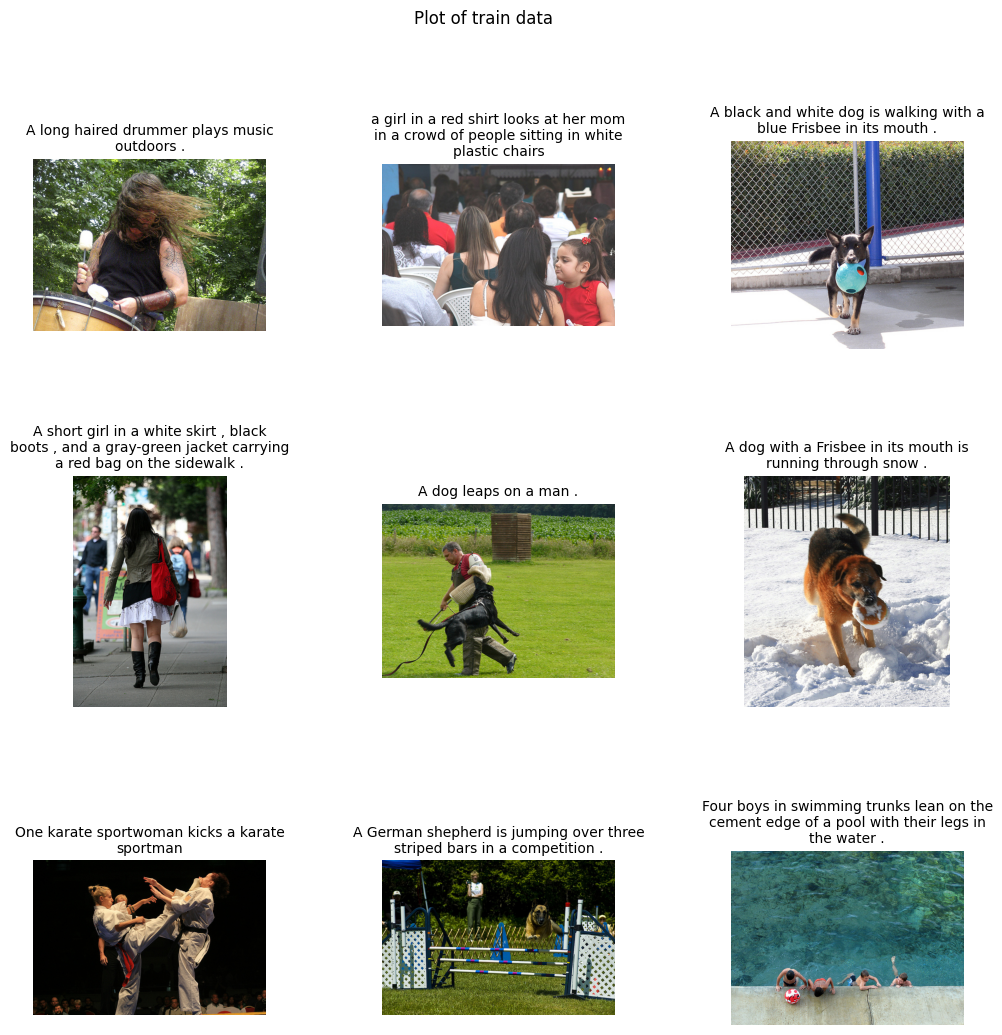

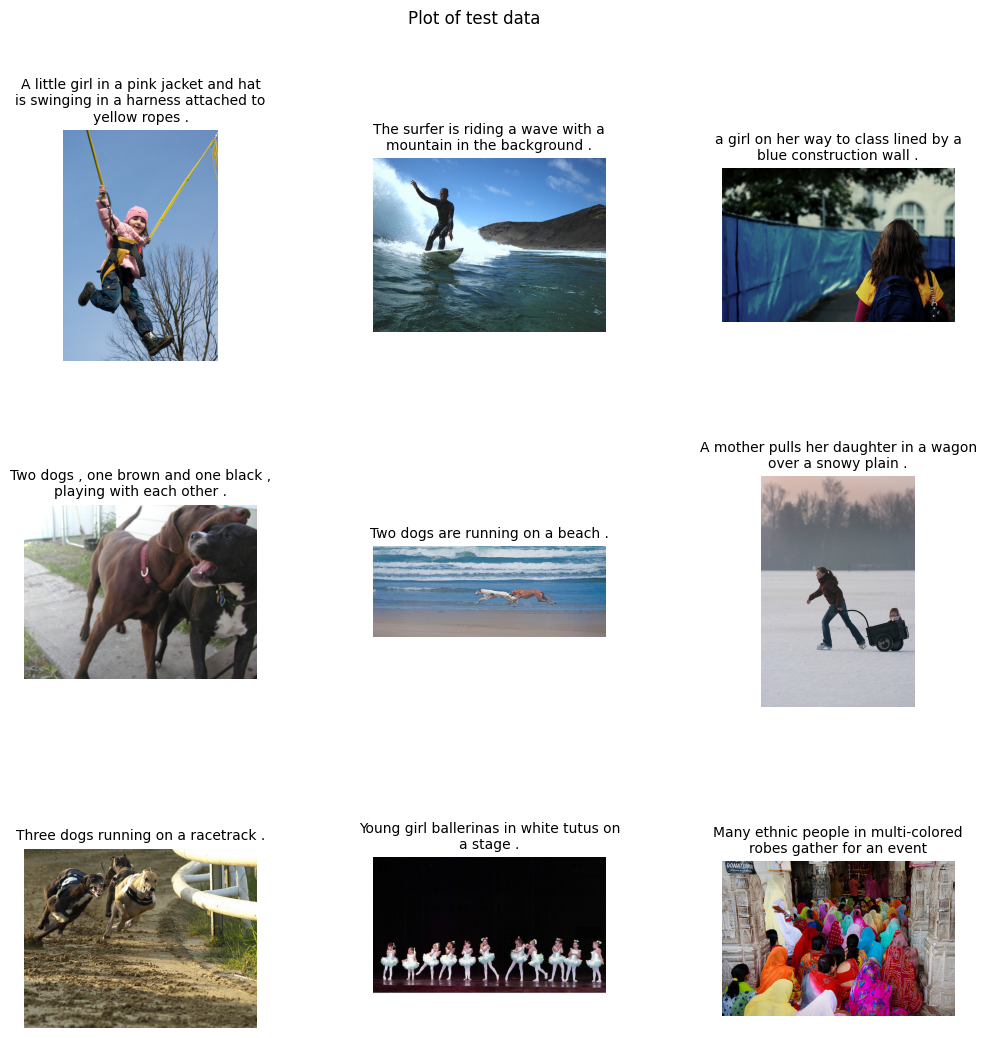

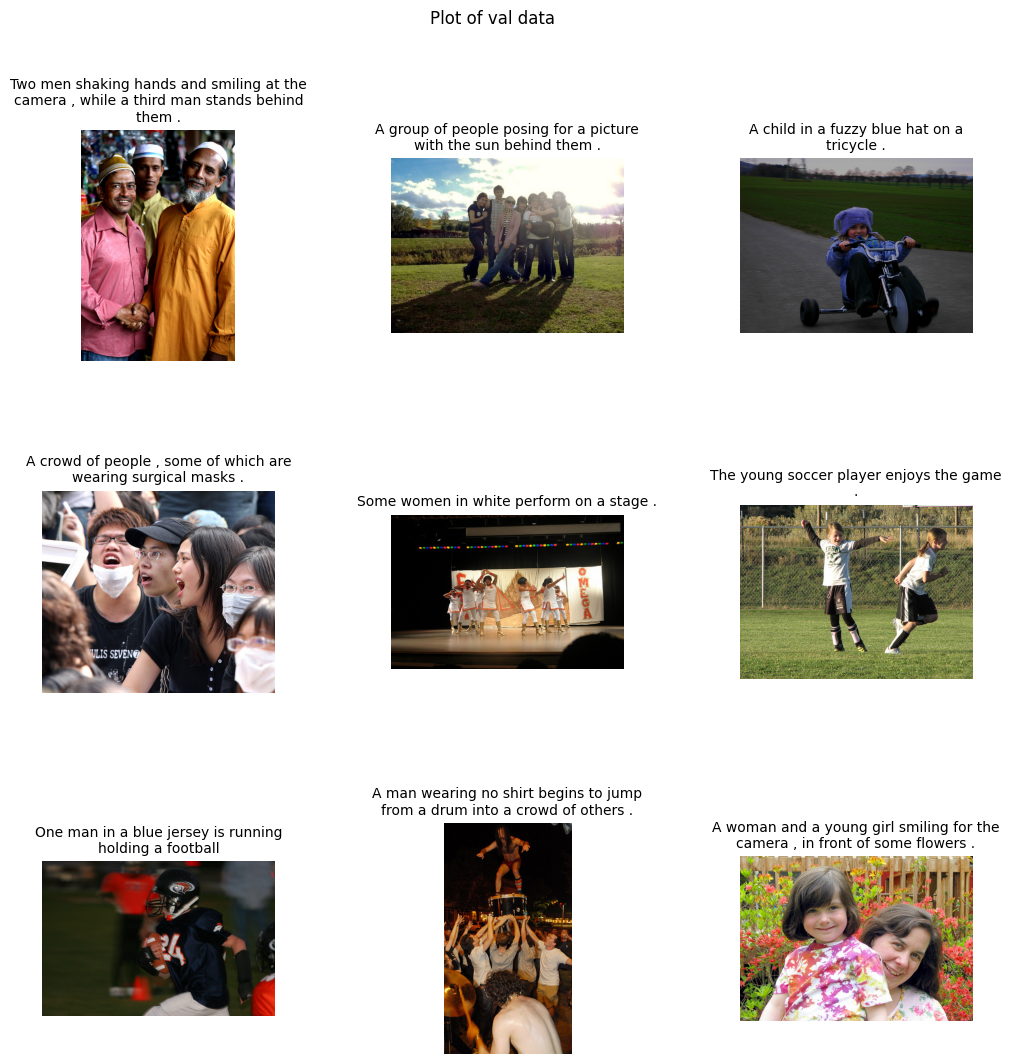

In [13]:
for k, data in data_dict.items():
    image_grid = ImageGridPlotter(data, images_path)
    image_grid.plot_image_grid(3, title=f"Plot of {k} data")
    
    del image_grid

## Preprocess all captions and save tokenizer to file

In [15]:
preprocess_caption = Preprocess_caption()
preprocess_caption.clean_captions_wrapper(pd.concat(data_dict.values()))
preprocess_caption.tokenize_captions()
print("Vocab size - {}".format(preprocess_caption.get_vocab_size()))
preprocess_caption.save_load_tokenizer("tokenizer.pkl")
# preprocess_caption.cleaned_caption_df.iloc[0]["caption"]

Vocab size - 8831
Saved Tokenizer to /kaggle/working/tokenizer.pkl


## Create Features for train, test and val and save to feature file

In [9]:
for key, data in data_dict.items():
    feature_extraction = Extract_features(images_path)
    # feature_extraction.create_feature_extraction_model(inception_model=True)
    feature_extraction.create_feature_extraction_model(inception_model=False)
    feature_extraction.get_image_features(
        dataframe=data,
        target_size=(224, 224, 3)
    )
    print("Number of features in {} - {}".format(key, len(feature_extraction.get_features().keys())))
    feature_extraction.save_load_features("image_features_{}.npy".format(key))
    
    del feature_extraction


Extracting features from Images:
-> Completed - 0 3405720825_b6991005eb.jpg
-> Completed - 1 115684808_cb01227802.jpg
-> Completed - 2 509241560_00e5b20562.jpg
-> Completed - 3 2256320794_0286c31bfa.jpg
-> Completed - 4 2749124446_d4432787b5.jpg
-> Completed - 5 3191982761_88793192ed.jpg
-> Completed - 6 2502007071_82a8c639cf.jpg
-> Completed - 7 3319338707_892ae2a660.jpg
-> Completed - 8 762947607_2001ee4c72.jpg
-> Completed - 9 2831656774_36982aafdb.jpg
-> Completed - 10 3286111436_891ae7dab9.jpg
-> Completed - 11 3268175963_113d90d178.jpg
-> Completed - 12 2766325714_189bbff388.jpg
-> Completed - 13 2100735137_05c6079537.jpg
-> Completed - 14 3271252073_0a1b9525fc.jpg
-> Completed - 15 2816259113_461f8dedb0.jpg
-> Completed - 16 150582765_bad8dec237.jpg
-> Completed - 17 2787868417_810985234d.jpg
-> Completed - 18 3673035152_da7ed916d9.jpg
-> Completed - 19 2302516347_26054442f9.jpg
-> Completed - 20 412203580_2c7278909c.jpg
-> Completed - 21 2228167286_7089ab236a.jpg
-> Completed 

## Loaded saved features, preprocessed caption tokenizer and create data for model training/testing

In [ ]:
# Create 2 partitions of train data
temp_data_dict = dict()
length = data_dict["train"].shape[0] // 2
temp_data_dict["train_1"] = data_dict["train"].iloc[:length]
temp_data_dict["train_2"] = data_dict["train"].iloc[length:]

save_x = False

preprocess_caption = Preprocess_caption()
preprocess_caption.clean_captions_wrapper(pd.concat(data_dict.values()))
preprocess_caption.save_load_tokenizer("tokenizer.pkl", saved_dataset_path, False)

for key, data in data_dict.items():
    print("\n\n## Preparing data for {}".format(key))
    feature_extraction = Extract_features()
    feature_extraction.save_load_features("image_features_{}.npy".format(key), saved_dataset_path, False)

    for i in temp_data_dict if key == "train" else range(1):
        if key != "train":
            k = key
            dt = data
        else:
            print("Started for - {}".format(i))
            k = i
            dt = temp_data_dict[i]
        
        if save_x == True:
            # Save X data
            model_data_preparation = Model_data_preparation(extract_features_class=feature_extraction, preprocess_caption_class=preprocess_caption, save_x_data=True)
            model_data_preparation.generate_sequences_wrapper(dt)
            model_data_preparation.save_prepared_data("prepared_data_{}".format(k))
        else:
            # Save y data
            model_data_preparation = Model_data_preparation(extract_features_class=feature_extraction, preprocess_caption_class=preprocess_caption, save_x_data=False)
            model_data_preparation.generate_sequences_wrapper(dt)
            model_data_preparation.save_prepared_data("prepared_data_{}".format(k))

    del feature_extraction, model_data_preparation

    print("## Completed preparing data for {}".format(key))

Loaded Tokenizer from /kaggle/input/feature-and-tokenizer-files/tokenizer.pkl


## Preparing data for train
Loaded features from /kaggle/input/caption-generation-suing-densenet/image_features_train.npy
Started for - train_1
Filtered cleaned df - (2831, 2)
X1	-> (0,)
X2	-> (0,)
y	-> (167147, 8831)
Saved y_train to /kaggle/working/prepared_data_train_1_y.dat
Started for - train_2
Filtered cleaned df - (2832, 2)
X1	-> (0,)
X2	-> (0,)
y	-> (166397, 8831)
Saved y_train to /kaggle/working/prepared_data_train_2_y.dat
## Completed preparing data for train


## Preparing data for test
Loaded features from /kaggle/input/caption-generation-suing-densenet/image_features_test.npy
Filtered cleaned df - (1214, 2)
X1	-> (0,)
X2	-> (0,)
y	-> (71445, 8831)
Saved y_train to /kaggle/working/prepared_data_test_y.dat
## Completed preparing data for test


## Preparing data for val
Loaded features from /kaggle/input/caption-generation-suing-densenet/image_features_val.npy
Filtered cleaned df - (1214, 2)
X1	-

## Merge np.memmap data files

In [8]:
# Merge train_1 and train_2 files
import numpy as np

path = "/kaggle/input/caption-generation-suing-densenet/"
file1 = os.path.join(path, "prepared_data_train_1_y.dat")
file2 = os.path.join(path, "prepared_data_train_2_y.dat")
ouput_path = "/kaggle/input/caption-generation-suing-densenet/"
ouput_file = os.path.join(ouput_path, "prepared_data_train_y.dat")

# Load the first memmap file
file1 = np.memmap(file1, dtype='float32', mode='r')  # Replace dtype with the correct type
# Load the second memmap file
file2 = np.memmap(file2, dtype='float32', mode='r')  # Replace dtype with the correct type

# Assuming both files have the same number of columns and compatible shapes
# Concatenate along the first axis (rows)
merged_array = np.concatenate((file1, file2), axis=0)  # Use axis=1 if merging columns

# Create a new memmap file for the merged data
merged_file = np.memmap(ouput_file, dtype='float32', mode='w+', shape=merged_array.shape)

# Write the merged array to the new memmap file
merged_file[:] = merged_array

# Flush the memmap to ensure data is written
merged_file.flush()

# Optionally, close the memmap file if you're done
del merged_file

## Load prepared data for model training/testing and train the model

Loaded config from /kaggle/input/feature-and-tokenizer-files/prepared_data_train_config.json
Loaded config from /kaggle/input/feature-and-tokenizer-files/prepared_data_val_config.json
Loaded model from - /kaggle/input/caption-generation-models/inception.checkpoint.model.keras


Model: "LSTM_Caption_Generation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 211)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 211, 256)  │  2,260,736 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 211, 256)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 211, 256)  │          0 │ batch_normalizat… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 211, 256)  │      1,024 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 211, 512)  │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 211, 256)  │    787,456 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 211, 256)  │      1,024 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 211, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ lstm_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8831)      │  2,269,567 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,111,039 (72.90 MB)

 Trainable params: 6,369,663 (24.30 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 12,739,328 (48.60 MB)

Epoch 1/3
5212/5212 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3965 - loss: 3.0276
Epoch 1: saving model to /kaggle/working/inception.checkpoint.model.keras
5212/5212 ━━━━━━━━━━━━━━━━━━━━ 483s 89ms/step - accuracy: 0.3965 - loss: 3.0276 - val_accuracy: 0.0657 - val_loss: 25.5156
Epoch 2/3
5212/5212 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3994 - loss: 2.9993
Epoch 2: saving model to /kaggle/working/inception.checkpoint.model.keras
5212/5212 ━━━━━━━━━━━━━━━━━━━━ 304s 58ms/step - accuracy: 0.3994 - loss: 2.9993 - val_accuracy: 0.0051 - val_loss: 27.8085
Epoch 3/3
5212/5212 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3991 - loss: 2.9541
Epoch 3: saving model to /kaggle/working/inception.checkpoint.model.keras
5212/5212 ━━━━━━━━━━━━━━━━━━━━ 304s 58ms/step - accuracy: 0.3991 - loss: 2.9541 - val_accuracy: 0.0075 - val_loss: 29.4070


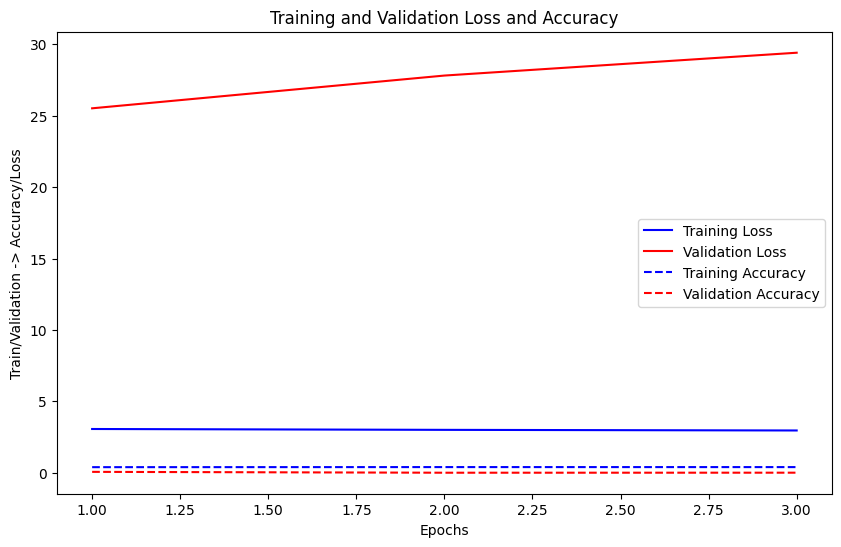

In [35]:
import tensorflow as tf

epochs = 3
batch_size = 64
embedding_dim=256
file = "inception.checkpoint.model.keras"
checkpoint_save_path = os.path.join(output_dir, file)
checkpoint_load_path = os.path.join(model_path, file)

data_gen_train = DataGenerator(
    input_dir=saved_dataset_path,
    filename="prepared_data_train",
    batch_size=batch_size
)

data_gen_val = DataGenerator(
    input_dir=saved_dataset_path,
    filename="prepared_data_val",
    batch_size=batch_size
)

# Get feature shape
(X1, _), _ = data_gen_train.__getitem__(0)
input_shape = X1[0].shape # (2048, )

with tf.distribute.MirroredStrategy().scope():
    caption_generation_model = Caption_generation_model()
#     caption_generation_model.create_lstm_model(
#         vocab_size=data_gen_train.config["vocab_size"],
#         embedding_dim=embedding_dim,
#         max_caption_length=data_gen_train.config["max_length"],
#         input_shape=input_shape
#     )
    # caption_generation_model.create_gru_model(
    #     vocab_size=data_gen_test.config["vocab_size"],
    #     embedding_dim=256,
    #     max_caption_length=data_gen_test.config["max_length"],
    #     input_shape=input_shape
    # )
    caption_generation_model.load_model(checkpoint_load_path)
#     caption_generation_model.load_checkpoint_model_weights(checkpoint_load_path)
    caption_generation_model.model_summary()
    caption_generation_model.compile_model()

    model_train = caption_generation_model.train_model(
        data_gen_train,
        epochs = epochs,
        validation_data=data_gen_val,
        checkpoint_path=checkpoint_save_path
    )
    caption_generation_model.plot_training_history(model_train)
#     caption_generation_model.model.save(checkpoint_save_path)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(caption_generation_model.model, show_shapes=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Loaded Tokenizer from /kaggle/input/feature-and-tokenizer-files/tokenizer.pkl
Loaded model from - /kaggle/input/caption-generation-models/inception.checkpoint.model.keras


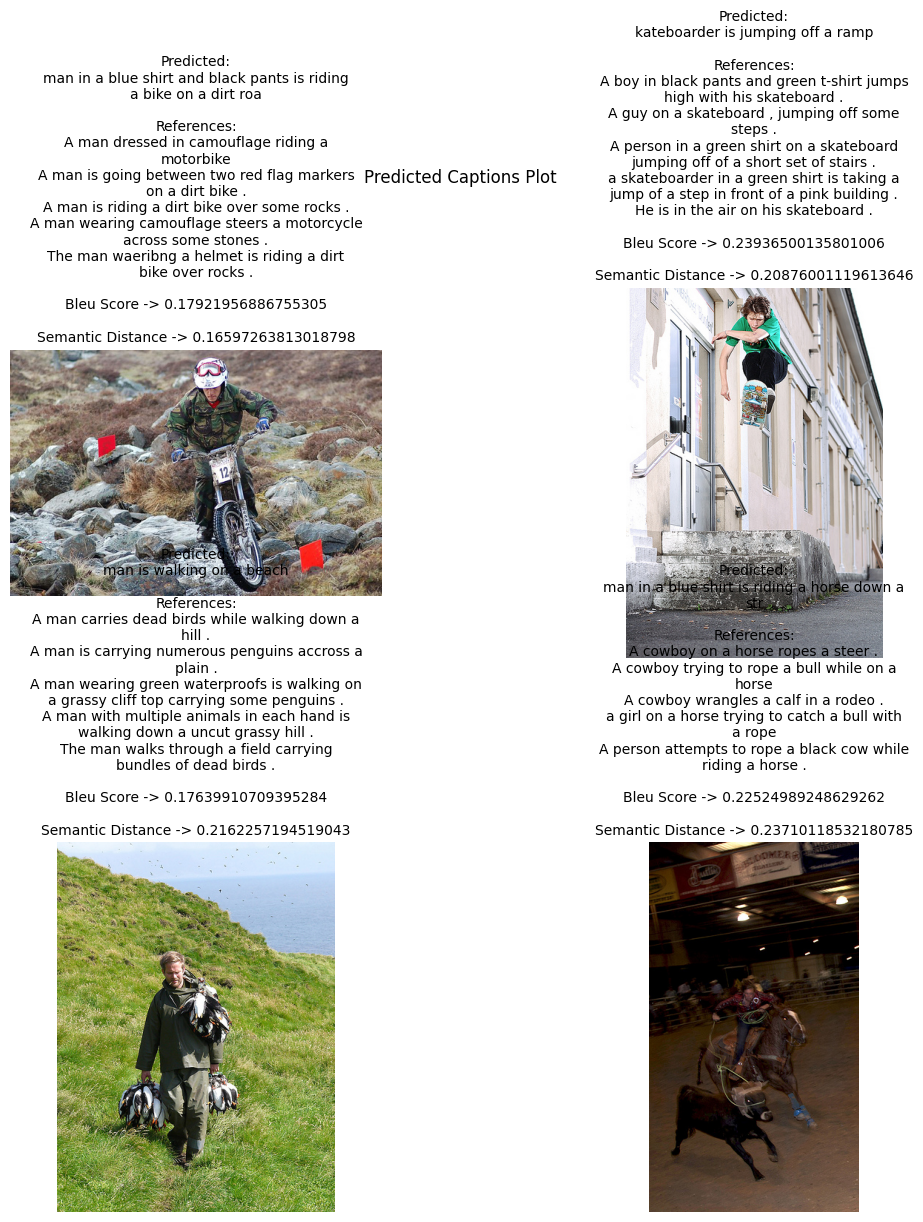

In [16]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from transformers import TFBertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the BERT model and tokenizer in TensorFlow
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = TFBertModel.from_pretrained(bert_model_name)

def get_embedding(text: str) -> np.ndarray:
    """Generate the BERT embedding for a given text using TensorFlow."""
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = model(**inputs)
    # Pooling: mean of token embeddings in the last hidden layer
    embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy().squeeze()
    return embeddings

custom_input_dir = "/kaggle/input/caption-generation-models"
image_path = os.path.join(model_path, "image_name.jpg")
load_model_path = os.path.join(model_path, "inception.checkpoint.model.keras")
# load_model_path = os.path.join(model_path, "inception.checkpoint.model_with add.keras")
# load_model_path = os.path.join(model_path, "densenet.checkpoint.model.keras")
target_size = (299, 299, 3)

# batch_size = 5
# data_gen_test = DataGenerator(
#     input_dir=saved_dataset_path,
#     filename="prepared_data_test",
#     batch_size=batch_size,
#     get_y_data=False
# )

# X1, _ = data_gen_test.__getitem__(0)

df = pd.DataFrame(columns=["image_name", "caption", "reference", "bleu_score", "semantic_distance"])
    
preprocess_caption = Preprocess_caption()
preprocess_caption.clean_captions_wrapper(pd.concat(data_dict.values()))
preprocess_caption.save_load_tokenizer("tokenizer.pkl", saved_dataset_path, False)
max_sentence_length = preprocess_caption.get_max_caption_length()

feature_extraction = Extract_features()
feature_extraction.create_feature_extraction_model()

caption_generation_model = Caption_generation_model()
caption_generation_model.load_model(load_model_path)

n_samples = 4

for _, (image_na, captions) in data_dict["val"].sample(n=n_samples).iterrows():
    custom_dir = os.path.join(images_path, image_na)

    img_feature = feature_extraction.generate_feature(custom_dir, target_size)

    # Predict the caption using your model
    predicted_caption = caption_generation_model.predict_model(
        img_feature, preprocess_caption.tokenizer, max_sentence_length
    )
    
    # Generate embeddings for the predicted caption and reference captions
    pred_embedding = get_embedding(predicted_caption)
    reference_captions = captions.tolist()
    reference_embeddings = [get_embedding(ref) for ref in reference_captions]
    
    # Calculate BLEU score
    bleu = sentence_bleu([ref.split() for ref in reference_captions], predicted_caption, smoothing_function=SmoothingFunction().method4)
#     bleu = corpus_bleu([ref.split() for ref in reference_captions], [predicted_caption.split()], weights=(1.0, 0, 0, 0))

    # Calculate average semantic distance (1 - cosine similarity) for each reference
    distances = [1 - cosine_similarity(pred_embedding.reshape(1, -1), ref_emb.reshape(1, -1)).item() for ref_emb in reference_embeddings]
    avg_distance = np.mean(distances)

    # Save results to DataFrame
    df.loc[len(df)] = [image_na, predicted_caption, reference_captions, bleu, avg_distance]

# print(df)
image_grid_output = ImageGridPlotter(df, images_path)
image_grid_output.plot_image_grid(n=n_samples//2, wrap_width=45, title="Predicted Captions Plot", bleu_score=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.1/387.1 kB 10.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 14.9 MB/s eta 0:00:00


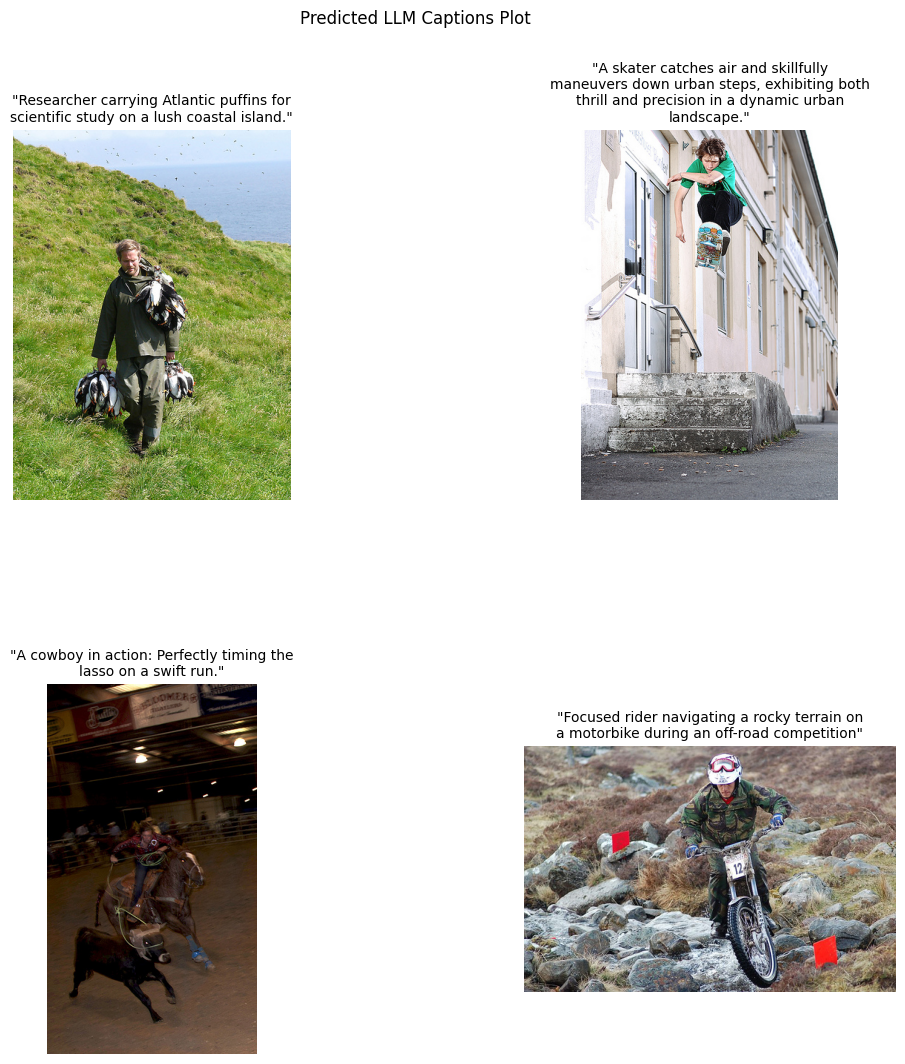

In [ ]:
!pip install openai pillow pytesseract

!pip install pytesseract
 
from PIL import Image

import pytesseract
 
# Set up your OpenAI API key

api_key = "<YOUR API KEY>"
 
from openai import OpenAI

import base64
 
client = OpenAI(

    # This is the default and can be omitted

    api_key=api_key

)

def encode_image_to_base64(image_path):

    # Open image, convert to base64

    with open(image_path, "rb") as image_file:

        img_b64_str = base64.b64encode(image_file.read()).decode("utf-8")

    img_type = Image.open(image_path).format.lower()  # e.g., 'jpeg', 'png'

    return img_b64_str, img_type
 
def generate_caption_with_image(image_path):

    # Encode image

    img_b64_str, img_type = encode_image_to_base64(image_path)

    # Create prompt for GPT-4 to generate a caption

    prompt = "Generate a caption for this image."

    # Send request to OpenAI API with image data embedded

    response = client.chat.completions.create(

        model="gpt-4-turbo",

        messages=[

            {

                "role": "user",

                "content": [

                    {"type": "text", "text": prompt},

                    {

                        "type": "image_url",

                        "image_url": {"url": f"data:image/{img_type};base64,{img_b64_str}"},

                    },

                ],

            }

        ]

    )

    # Extract caption from the response

    #print(response)

    caption = response.choices[0].message.content

    return caption
 
    
 
llm_output_df = pd.DataFrame(columns=["image_name", "caption"])

for img_name in df["image_name"]:
    # Replace 'your_api_key' with your actual OpenAI API key
    img_path = os.path.join(images_path, img_name)
    caption = generate_caption_with_image(img_path)
    
    llm_output_df.loc[len(llm_output_df)] = [img_name, caption]

image_grid_output = ImageGridPlotter(llm_output_df, images_path)
image_grid_output.plot_image_grid(n=n_samples//2, wrap_width=45, title="Predicted LLM Captions Plot")